In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
num_steps = 501
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([501, 14641])

In [5]:
N = datas.shape[1]
n = 20
mu = int(np.ceil(N/40))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [6]:
batch_size = 50
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [7]:
ed = lib.nrbs.EncoderDecoder(N=N, n=n, mu=mu, neighbours=neighbours, device=device)

In [8]:
encoded = ed.nrbs.encode(datas[:15].to(device))
encoded.shape

torch.Size([15, 20])

In [9]:
ed.train(train_data_loader=train_data, epochs=10)

100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Itr 0, loss = 19148.531125451802


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Itr 1, loss = 6626.8316092352225


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 2, loss = 2748.1900738252216


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 3, loss = 1933.9640333236796


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 4, loss = 1442.27399940602


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 5, loss = 963.8134401055755


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 6, loss = 755.7898627646352


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 7, loss = 637.8240733511182


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 8, loss = 526.834080569252


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Itr 9, loss = 437.6258669054845


In [10]:
vmap_bubble = vmap(ed.nrbs.bubble, in_dims=0)
vmap_vmap_bubble = vmap(vmap_bubble, in_dims=0)

In [11]:
# ed.nrbs = torch.load('models/nrbs_99.pth')

In [12]:
approximates = ed(datas[499:501].to(device))
approximates[1].shape

torch.Size([14641])

In [13]:
ed.nrbs.decode(encoded).shape

torch.Size([15, 14641])

In [14]:
approximates[1]

tensor([ 1.4407e-02,  1.6110e-02,  1.4947e-02,  ..., -1.7445e-04,
         3.4973e-05,  5.4685e-06], device='cuda:0', grad_fn=<SelectBackward0>)

In [15]:
datas[500]

tensor([1.3673e-02, 1.3859e-02, 1.4044e-02,  ..., 6.5629e-31, 6.5629e-31,
        9.4247e-31])

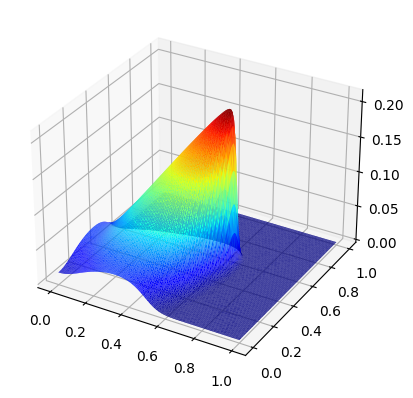

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(coords_x, coords_y, datas[500], cmap=cm.jet, linewidth=0)

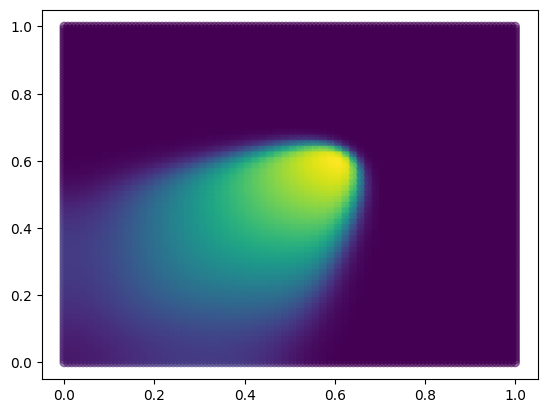

In [17]:
plt.scatter(coords_x, coords_y, c=datas[500], alpha=0.5)

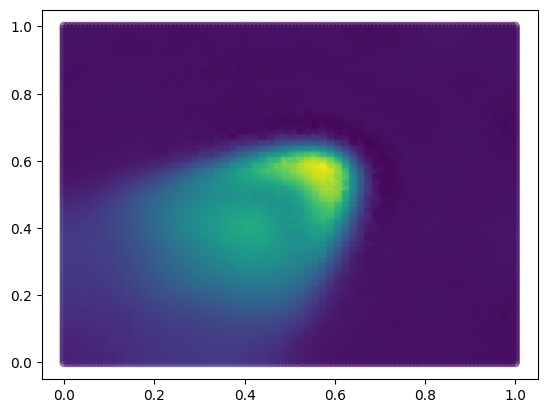

In [18]:
plt.scatter(coords_x, coords_y, c=approximates[1].detach().cpu(), alpha=0.5)

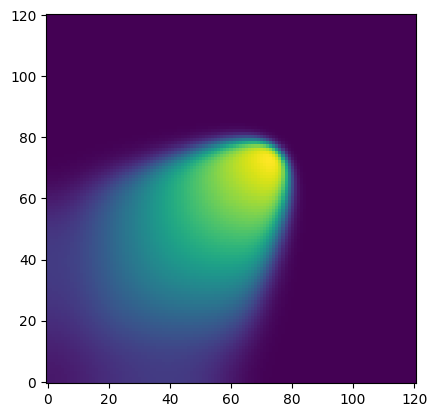

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[500].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,121)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower')

In [20]:
zi

array([[1.36734000e-02, 1.37186000e-02, 1.38589992e-02, ...,
        2.00412925e-16, 8.64125049e-17, 5.87878000e-17],
       [1.37186000e-02, 1.37637001e-02, 1.39039993e-02, ...,
        2.02056185e-16, 8.71171981e-17, 5.92657002e-17],
       [1.38589992e-02, 1.39039993e-02, 1.40438985e-02, ...,
        2.06949847e-16, 8.92158891e-17, 6.06898921e-17],
       ...,
       [2.00413058e-16, 2.02055906e-16, 2.06949594e-16, ...,
        4.65475011e-30, 2.09314912e-30, 1.45650191e-30],
       [8.64124954e-17, 8.71169710e-17, 8.92159808e-17, ...,
        2.09315318e-30, 9.42511941e-31, 6.56311624e-31],
       [5.87878000e-17, 5.92657002e-17, 6.06898919e-17, ...,
        1.45650024e-30, 6.56310705e-31, 4.57194000e-31]])